# Aligning signals with cross-correlation

In [95]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn import preprocessing

sns.set_theme()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [96]:
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S.%f(UTC-07:00)"

MinMaxScaler is a transformation given by:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

I use it to fit data to 0-1 range. It is mostly useful for putting them in one graph at the moment.

In [97]:
min_max_scaler = preprocessing.MinMaxScaler()

Load PPG data. I am using just `red` readings at the moment.

In [98]:
ppg_fpath = Path(
    "/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/PPG_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")
ppg_df = pd.read_csv(ppg_fpath)
ppg_df['red'] = min_max_scaler.fit_transform((ppg_df['red'].array.reshape(-1, 1)))
ppg_df['ir'] = min_max_scaler.fit_transform((ppg_df['red'].array.reshape(-1, 1)))
ppg_df

,timestamp,localized,red,ir
0,1686782913042,2023-06-14T15:48:33.042(UTC-07:00),0.593143,0.593143
1,1686782913041,2023-06-14T15:48:33.041(UTC-07:00),0.596571,0.596571
2,1686782913040,2023-06-14T15:48:33.040(UTC-07:00),0.588571,0.588571
3,1686782913039,2023-06-14T15:48:33.039(UTC-07:00),0.587429,0.587429
4,1686782913037,2023-06-14T15:48:33.037(UTC-07:00),0.587429,0.587429
...,...,...,...,...
2555,1686782963623,2023-06-14T15:49:23.623(UTC-07:00),0.752000,0.752000
2556,1686782963643,2023-06-14T15:49:23.643(UTC-07:00),0.752000,0.752000
2557,1686782963663,2023-06-14T15:49:23.663(UTC-07:00),0.752000,0.752000
2558,1686782963683,2023-06-14T15:49:23.683(UTC-07:00),0.736000,0.736000


Load and scale IMU data

In [99]:
imu_fpath = Path(
    "/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/IMU_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")
imu_df = pd.read_csv(imu_fpath)
for dim in ('ax', 'ay', 'az', 'gx', 'gy', 'gz'):
    imu_df[dim] = min_max_scaler.fit_transform((imu_df[dim].array.reshape(-1, 1)))
imu_df

,timestamp,localized,ax,ay,az,gx,gy,gz
0,1686782913053,2023-06-14T15:48:33.053(UTC-07:00),0.525423,0.566652,0.377683,0.501534,0.466157,0.498747
1,1686782913047,2023-06-14T15:48:33.047(UTC-07:00),0.525717,0.567432,0.378829,0.501534,0.466181,0.498629
2,1686782913041,2023-06-14T15:48:33.041(UTC-07:00),0.524127,0.567002,0.379259,0.501762,0.466276,0.498590
3,1686782913036,2023-06-14T15:48:33.036(UTC-07:00),0.525688,0.567193,0.378657,0.501976,0.466395,0.498629
4,1686782913030,2023-06-14T15:48:33.030(UTC-07:00),0.525776,0.566382,0.378657,0.501717,0.466419,0.498727
...,...,...,...,...,...,...,...,...
5155,1686782964365,2023-06-14T15:49:24.365(UTC-07:00),0.418311,0.552012,0.483394,0.502663,0.466586,0.498159
5156,1686782964376,2023-06-14T15:49:24.376(UTC-07:00),0.418694,0.550898,0.484540,0.503120,0.466800,0.498199
5157,1686782964387,2023-06-14T15:49:24.387(UTC-07:00),0.420315,0.550644,0.483967,0.503151,0.467038,0.498257
5158,1686782964398,2023-06-14T15:49:24.398(UTC-07:00),0.419814,0.550500,0.482047,0.502968,0.467062,0.498492


The PPG and IMU data has different timestamps and resolutions: PPG has 2560 points and IMU has 5160. I need to put them together and interpolate missing values. Interpolation is done using previous existing value so for example: `[1,2,NaN,NaN,5]` becomes `[1,2,2,2,5]`.

Merge two dataframes using `localized`

In [100]:
df = pd.merge(imu_df, ppg_df, how='outer', left_on='localized', right_on='localized')

Convert column to Python-understandable `datetime` format.

In [101]:
df['dt'] = pd.to_datetime(df['localized'], format=DATE_FORMAT)

Sort by date

In [102]:
df = df.sort_values(by='dt')

Interpolate all columns with missing values

In [103]:
for dim in ('red', 'ax', 'ay', 'az', 'gx', 'gy', 'gz'):
    df[dim] = df[dim].interpolate(method='pad')

Drop unused columns

In [104]:
df = df.drop(columns=['ir', 'timestamp_x', 'timestamp_y', 'localized'])

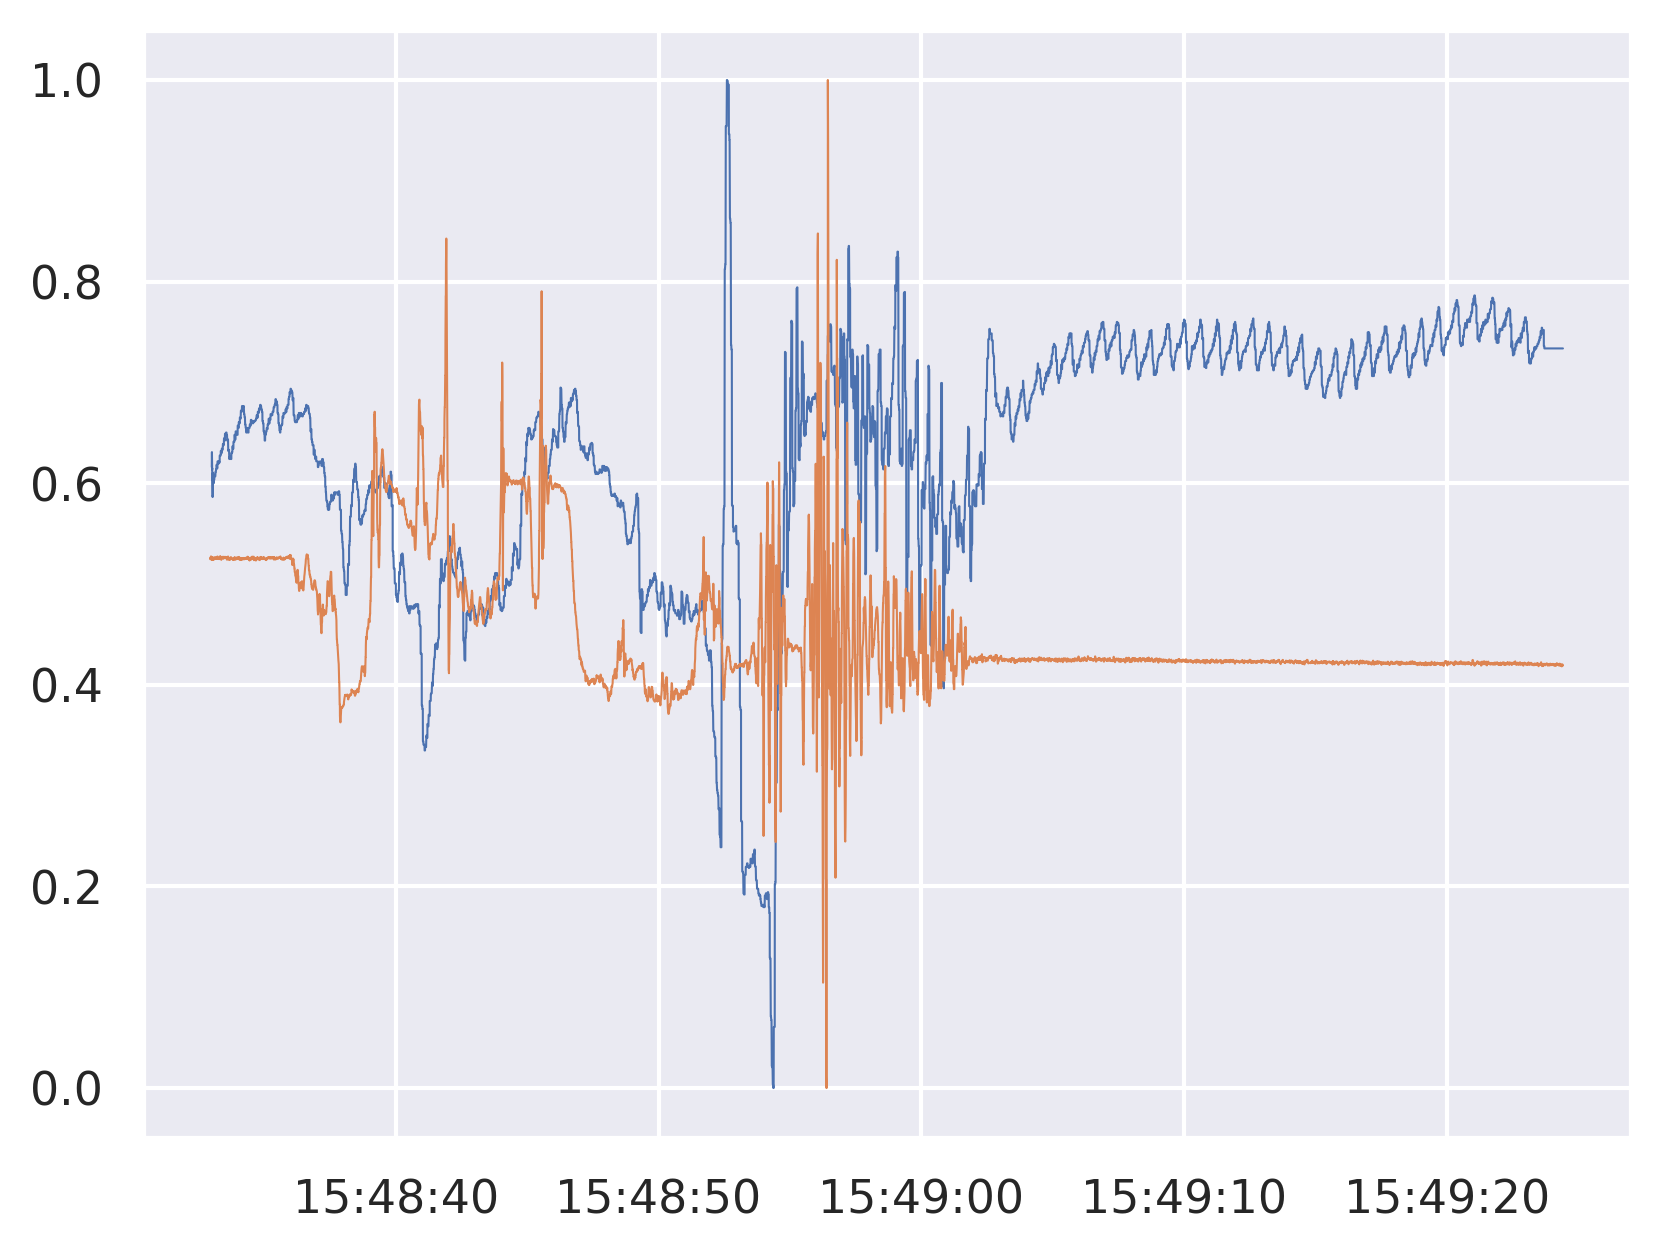

In [105]:
plt.plot(df['dt'], df['red'], lw=0.5)
plt.plot(df['dt'], df['ax'], lw=0.5)

Plotting the graphs - the PPG signal is in slight orange color on the IMU graphs.

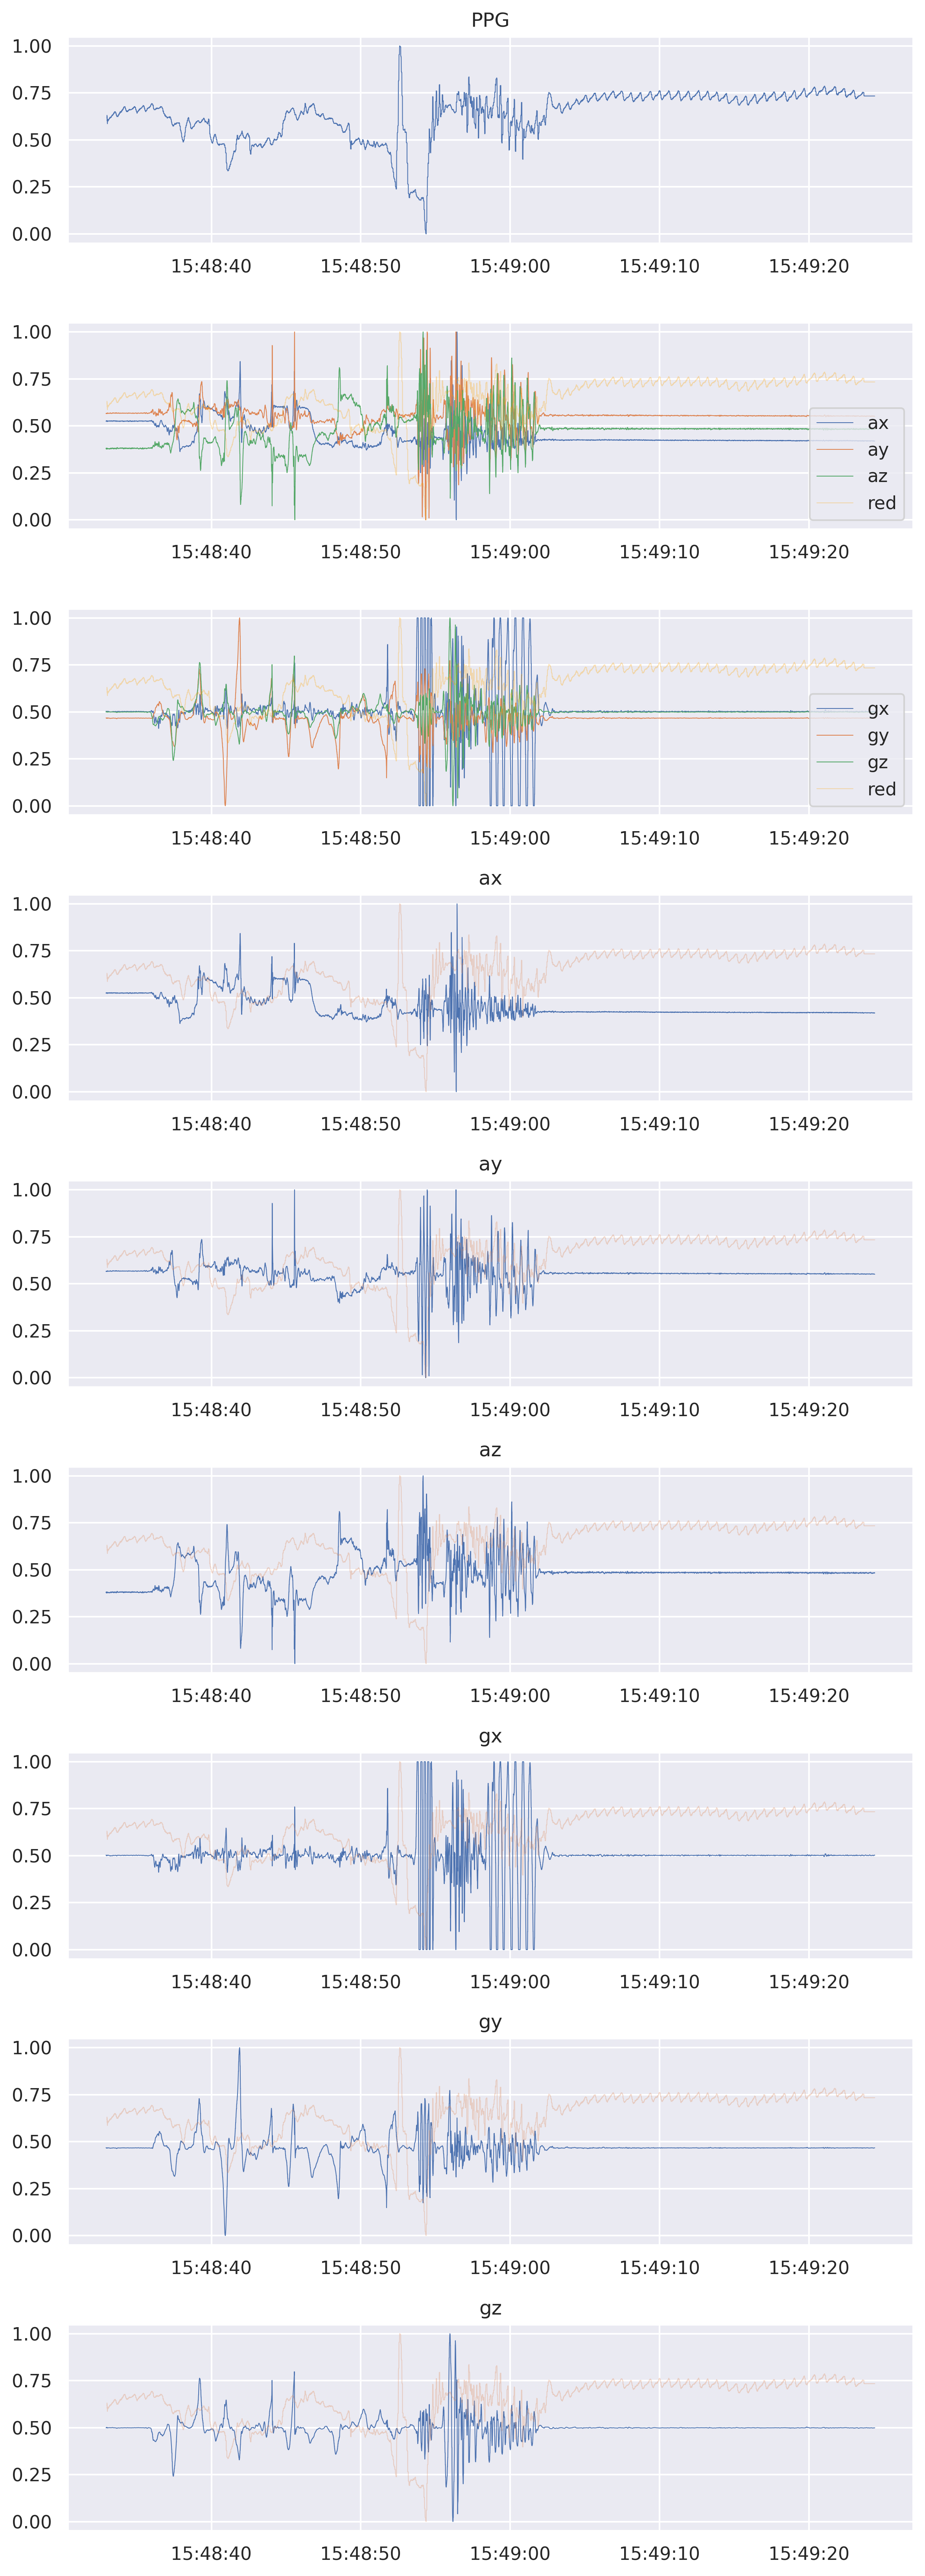

In [106]:
fig = plt.figure(figsize=(8, 22))
ax1 = plt.subplot(911)
ax1.plot(df['dt'], df['red'], lw=0.5)
ax1.set_title('PPG')
ax2 = plt.subplot(912, sharex=ax1)
ax2.plot(df['dt'], df['ax'], lw=0.5)
ax2.plot(df['dt'], df['ay'], lw=0.5)
ax2.plot(df['dt'], df['az'], lw=0.5)
ax2.plot(df['dt'], df['red'], lw=0.5, alpha=0.3, color='orange')
ax2.legend(['ax', 'ay', 'az', 'red'])
ax3 = plt.subplot(913, sharex=ax1)
ax3.plot(df['dt'], df['gx'], lw=0.5)
ax3.plot(df['dt'], df['gy'], lw=0.5)
ax3.plot(df['dt'], df['gz'], lw=0.5)
ax3.plot(df['dt'], df['red'], lw=0.5, alpha=0.3, color='orange')
ax3.legend(['gx', 'gy', 'gz', 'red'])
for it, dim in enumerate(('ax', 'ay', 'az', 'gx', 'gy', 'gz')):
    ax = plt.subplot(914 + it, sharex=ax1)
    ax.plot(df['dt'], df[dim], lw=0.5)
    ax.plot(df['dt'], df['red'], lw=0.5, alpha=0.3)
    ax.set_title(dim)

plt.tight_layout()
plt.savefig('PPG_IMU.png')

Select the column that we want to correlate with. `ax` isn't very well correlated with the PPG signal. It's tricky - we need to check if it works for other signals as well.

In [0]:
axis = df['ay']

Cross-correlation
$$c_{k} = \sum_{n=0}^{N} f(n)g(n+l)$$

Subtracting the mean gets rid of the (significant) DC component. Without it cross-correlation is useless.

`same` means that it returns output of length `max(M,N)`.

In [153]:
c = np.correlate(np.array(df['red'] - df['red'].mean()), np.array(axis - axis.mean()), mode='same')

Create array that represent  correlation values. Basically `[-3710 ... 0 ... 3710]` in this case.

In [156]:
lags = scipy.signal.correlation_lags(df['red'].size, axis.size, mode="same")

There's an issue with this signal correlation, because the max correlation value doesn't represent the actual lag, that we are interested in.

3710
728 728


Text(1, 16, 'global max')

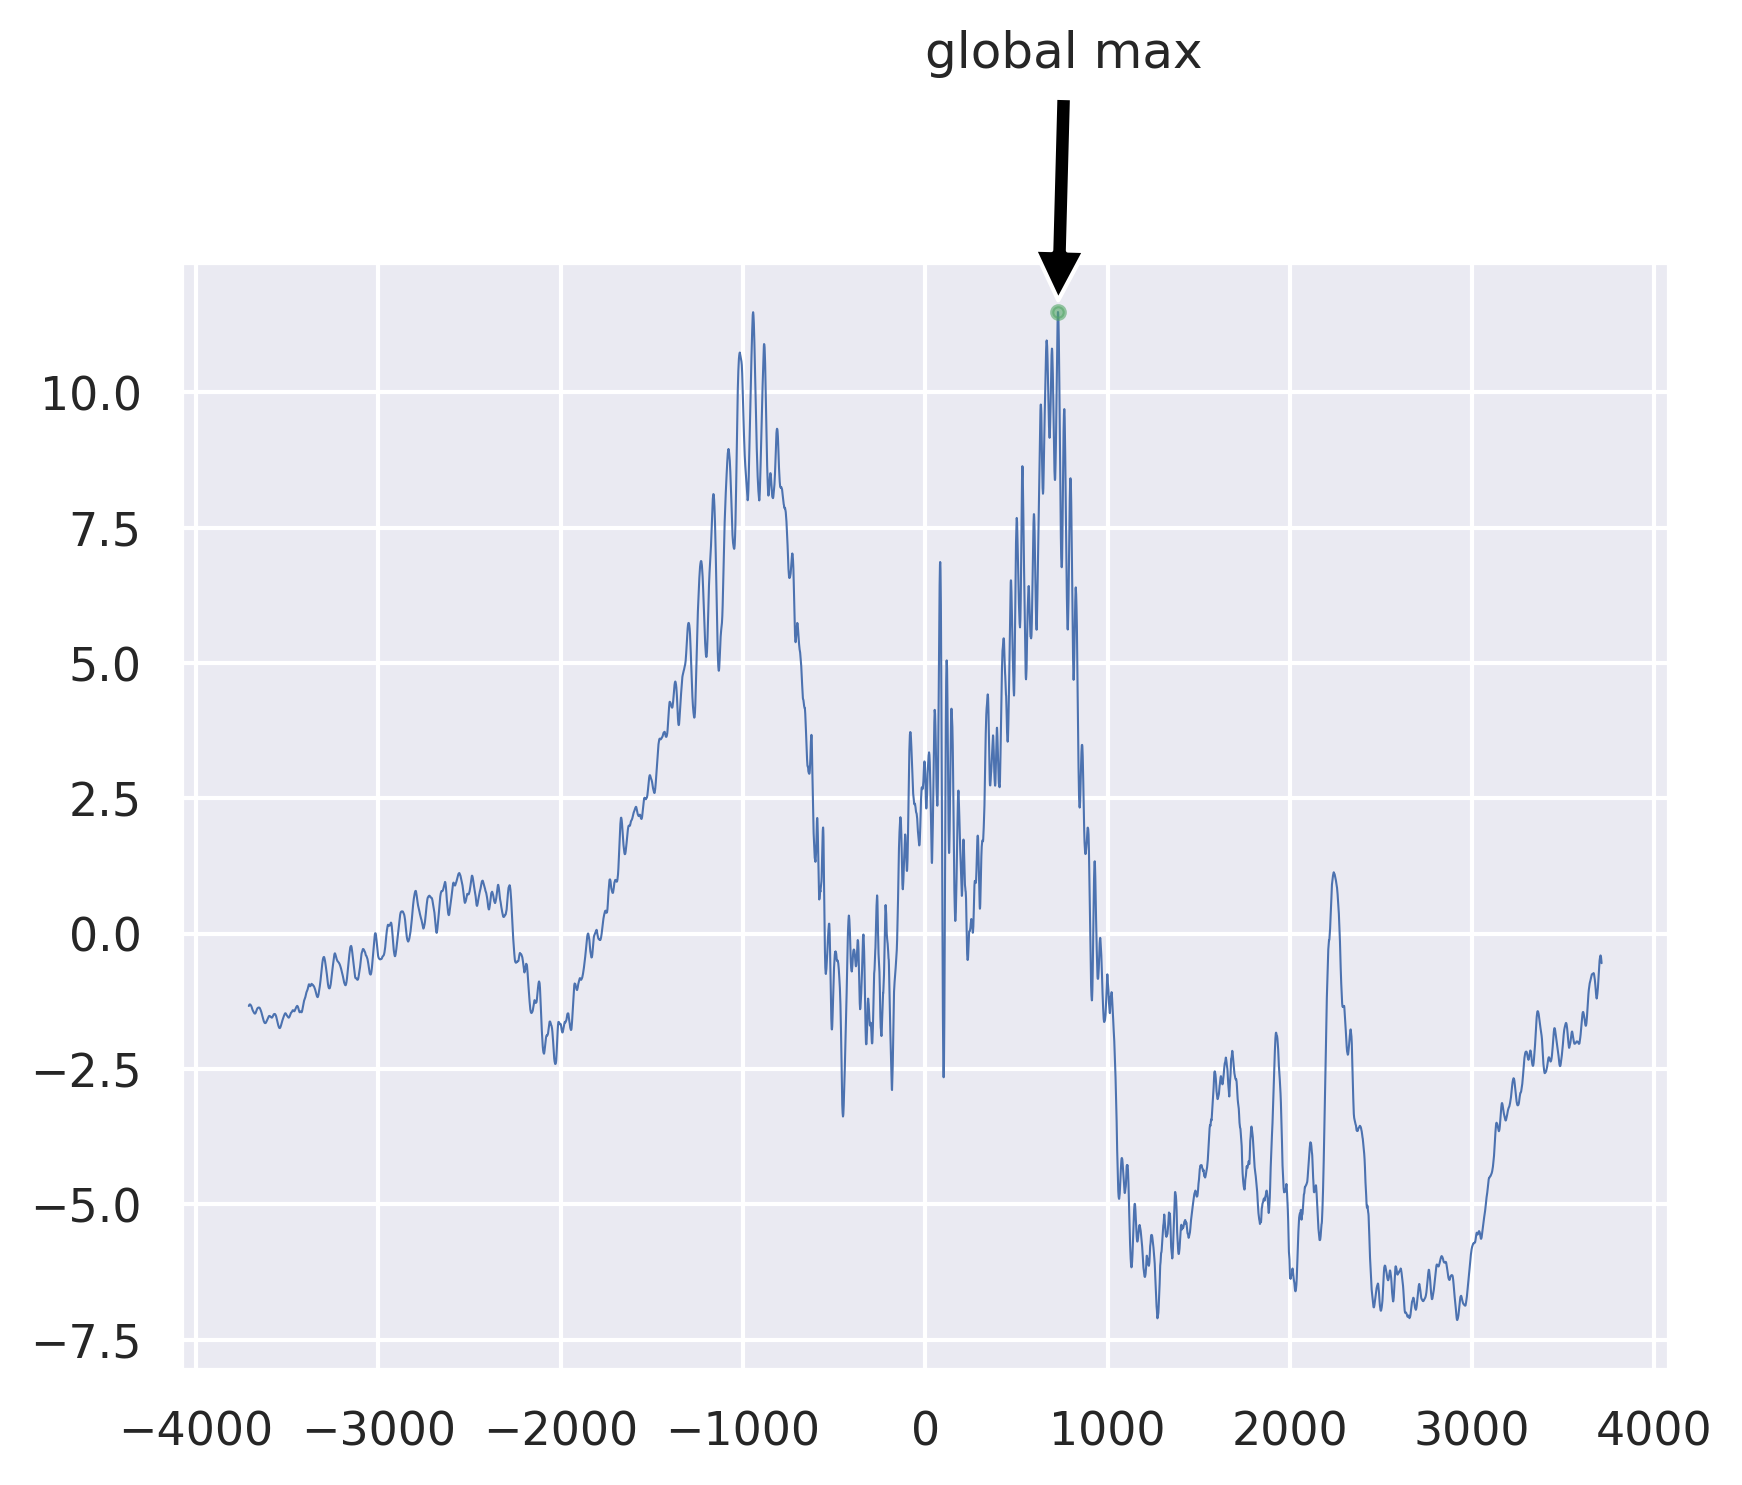

In [188]:
c_pos = np.argmax(c)
c_lag = lags[c_pos]
plt.plot(lags, c, lw=0.5)
plt.plot(lags[c_pos], c[c_pos], 'go', markersize=3, alpha=0.6)
plt.annotate('global max', xy=(lags[c_pos], c[c_pos]), xytext=(1, 16),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

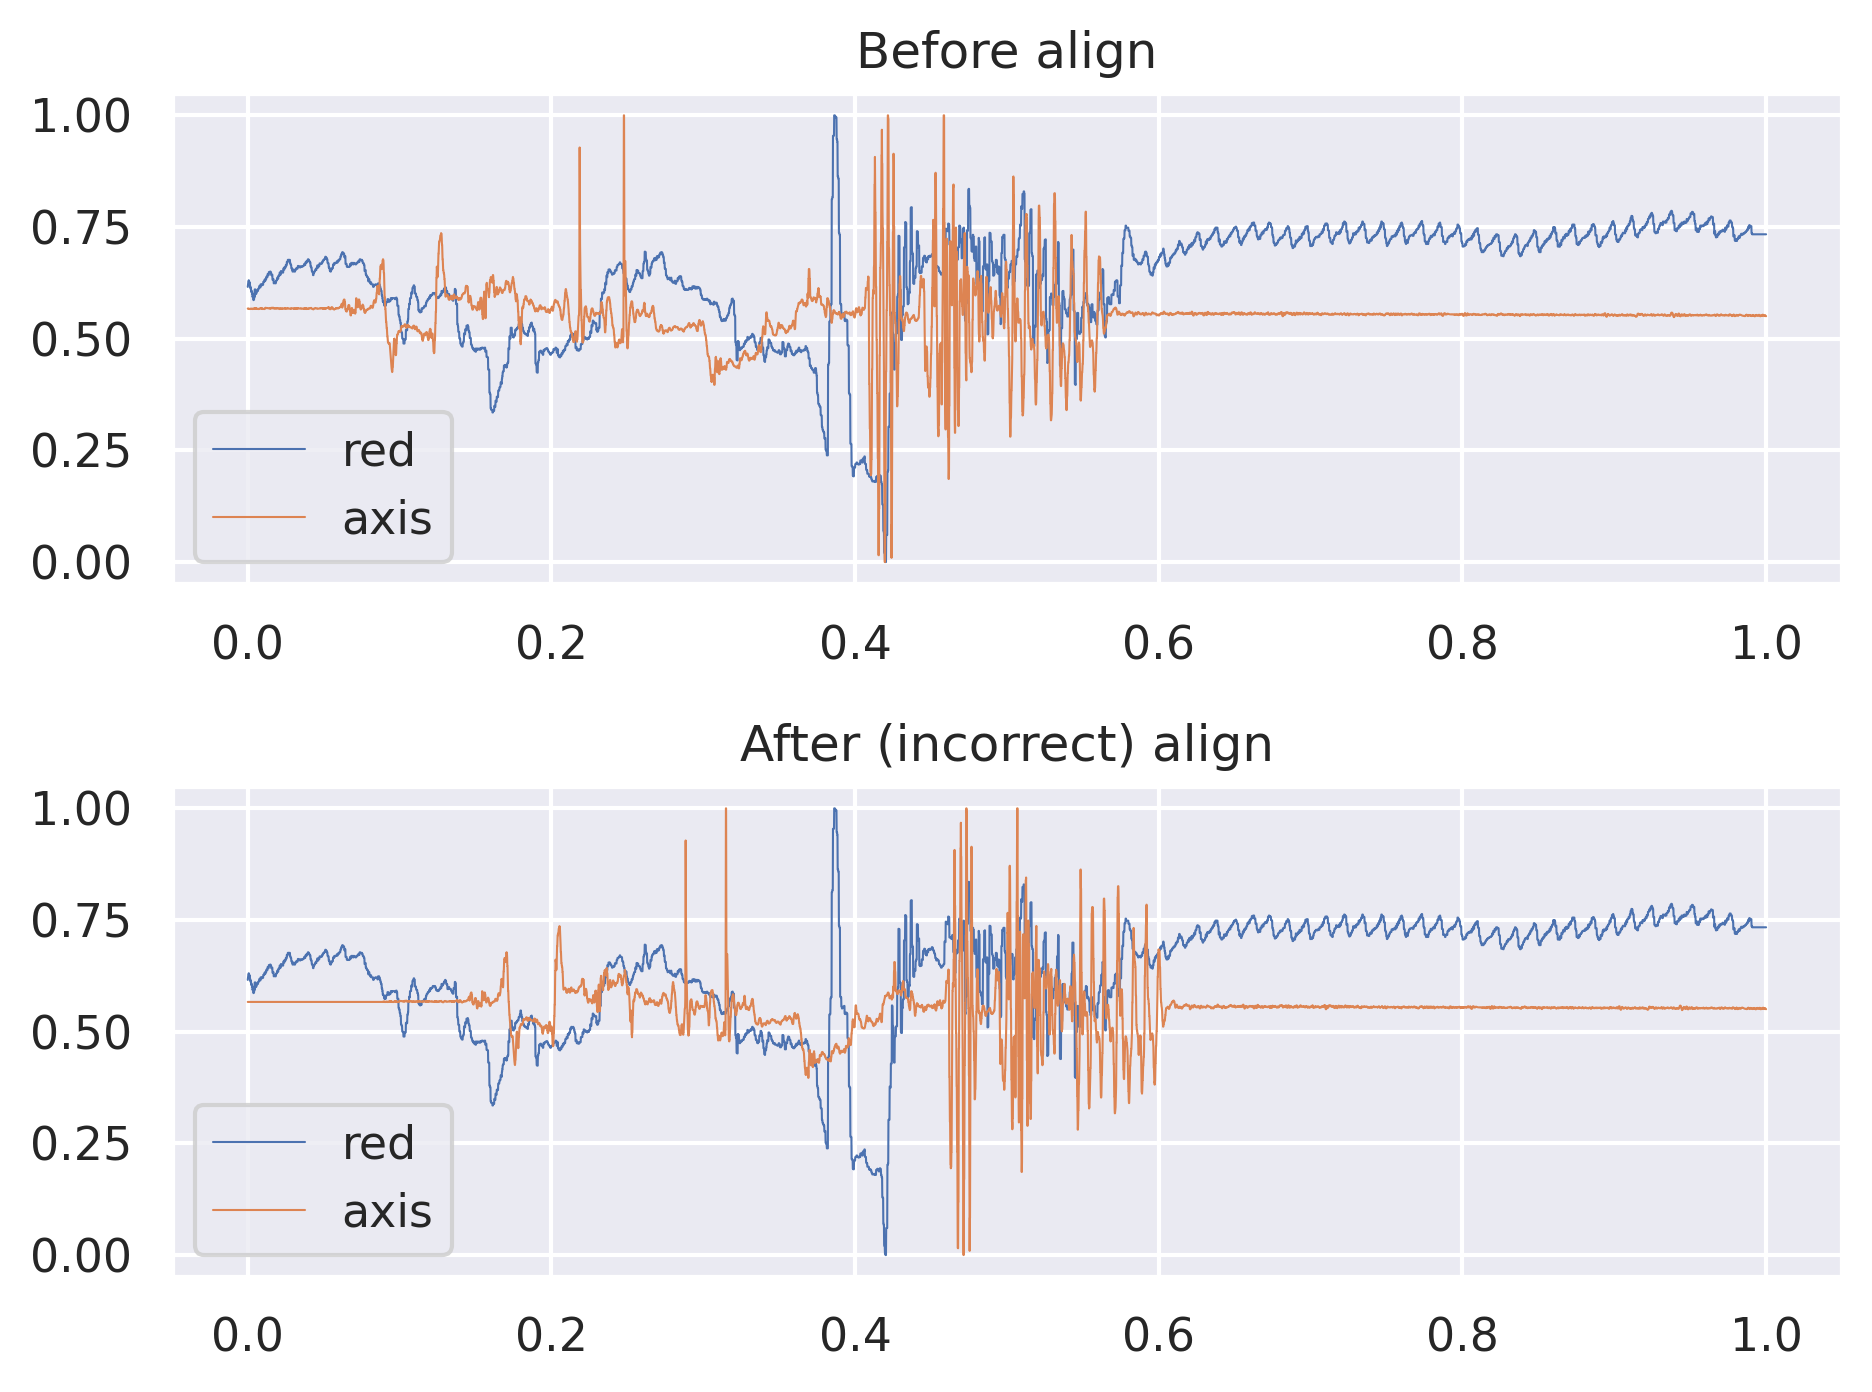

In [190]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(np.linspace(0, 1, len(df['red'])), df['red'], lw=0.5)
ax1.plot(np.linspace(0, 1, len(axis)), axis, lw=0.5)
ax1.legend(['red', 'axis'])
ax1.set_title('Before align')
ax2 = plt.subplot(212)
ax2.set_title('After (incorrect) align')
ax2.plot(np.linspace(0, 1, len(df['red'])), df['red'], lw=0.5)
ax2.plot(np.linspace(0, 1, len(axis) + c_lag), np.concatenate((np.ones(c_lag) * axis[0], np.array(axis)), axis=0), lw=0.5)
ax2.legend(['red', 'axis'])
plt.tight_layout()

To solve this issue I assumed that overall lag would be contained in a small window (arbitrarily +-250 samples) and computed local max only for that window.

In [169]:
BAND = 500
LOW_BOUND = (len(c) // 2) - BAND // 2
HIGH_BOUND = (len(c) // 2) + BAND // 2
print(f"lower bound: {LOW_BOUND}, higher bound: {HIGH_BOUND}, band width: {BAND}")

lower bound: 3460, higher bound: 3960, band width: 500


In [201]:
truncated_c = np.argmax(c[LOW_BOUND:HIGH_BOUND])
print("argmax:\t\t\t", truncated_c)
lag = lags[LOW_BOUND + truncated_c]
print("Computed lag:\t", lag)

argmax:			 332
Computed lag:	 82


Text(1, 13, 'local max')

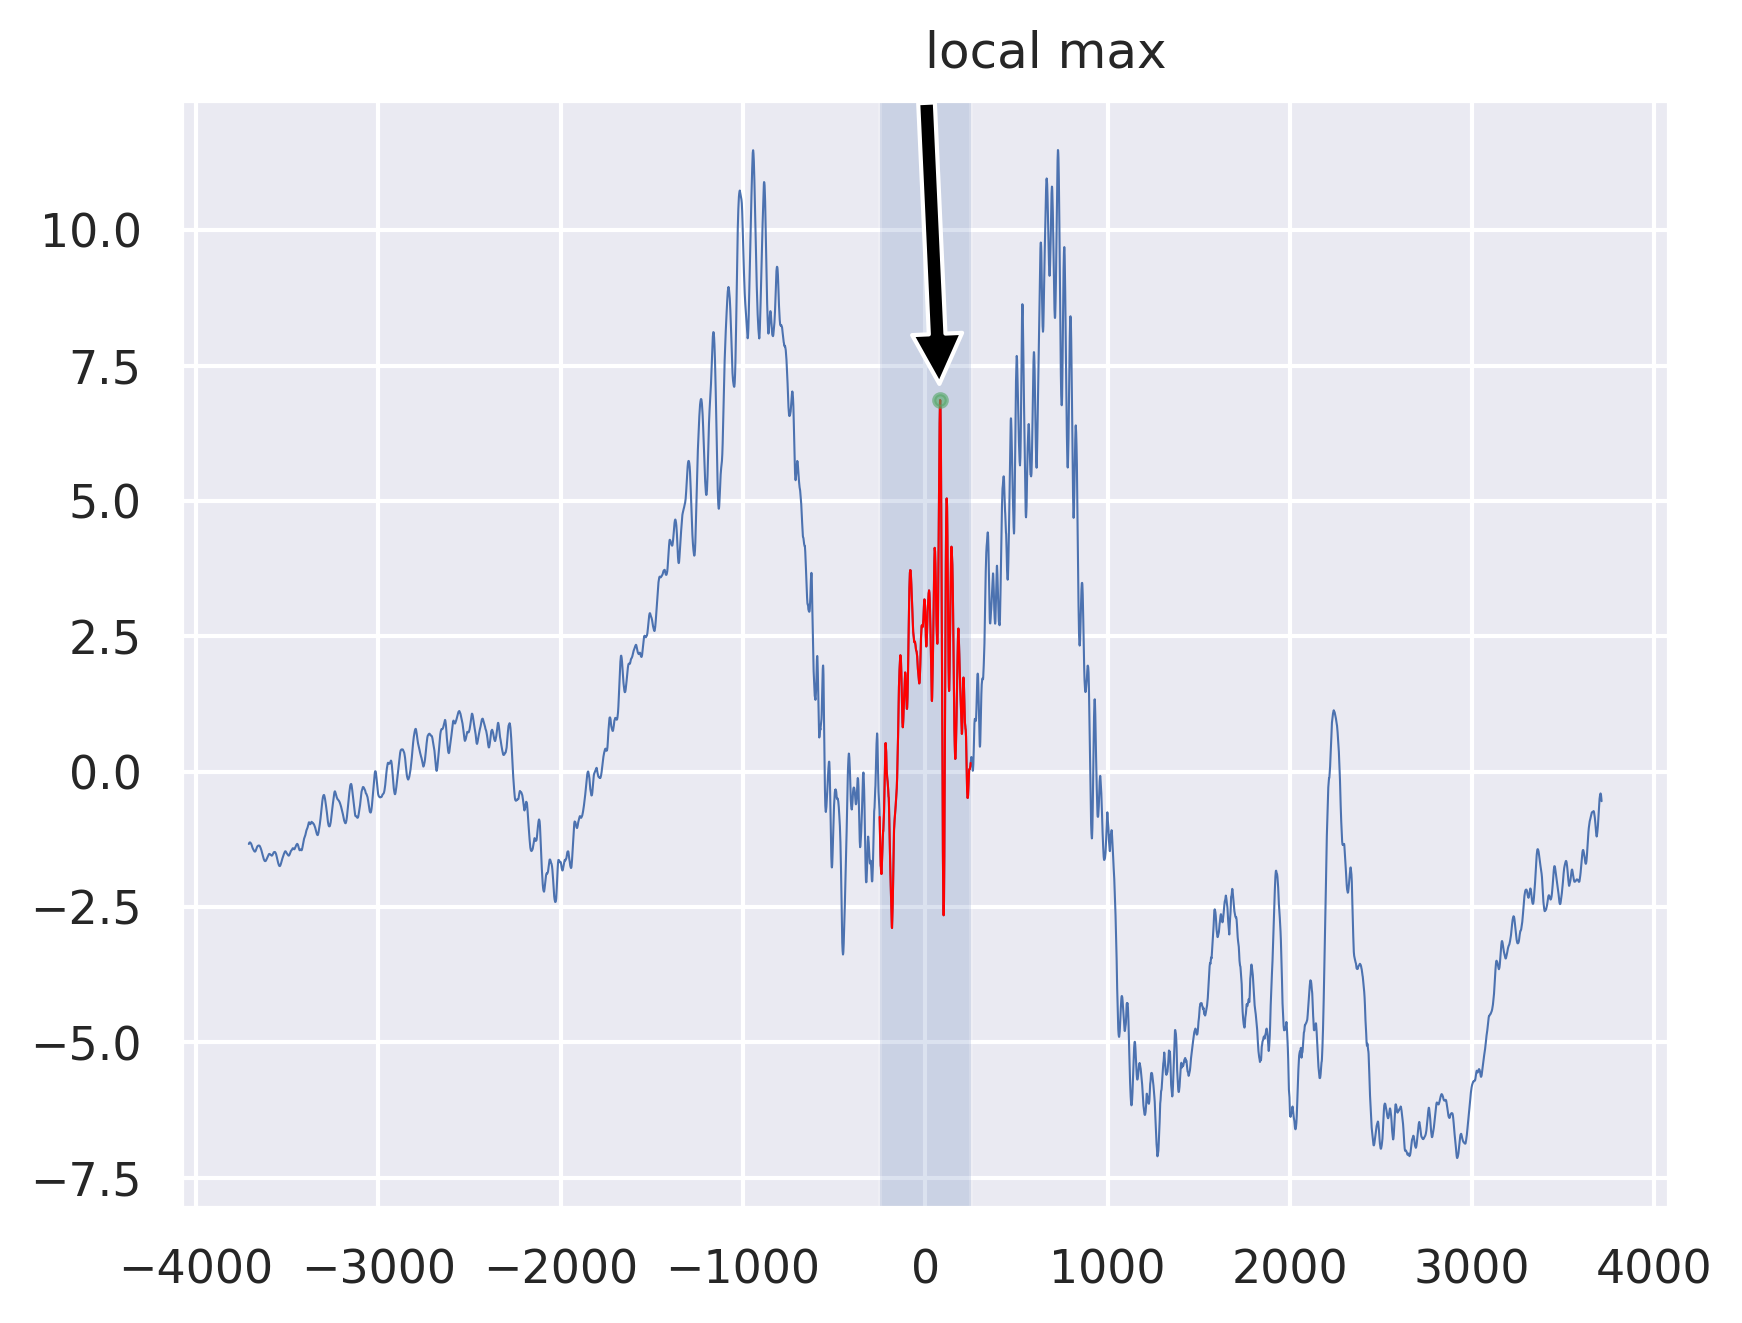

In [207]:
plt.plot(lags, c, lw=0.5)
plt.plot(lags[LOW_BOUND:HIGH_BOUND], c[LOW_BOUND:HIGH_BOUND], lw=0.5, color='red')
middle_point = np.argwhere(lags == 0)
lag_point = middle_point + lag
plt.plot(lags[lag_point], c[lag_point], 'go', markersize=3, alpha=0.6)
plt.axvspan(-BAND//2, BAND//2, alpha=0.2)
plt.annotate('local max', xy=(lags[lag_point], c[lag_point]), xytext=(1, 13),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

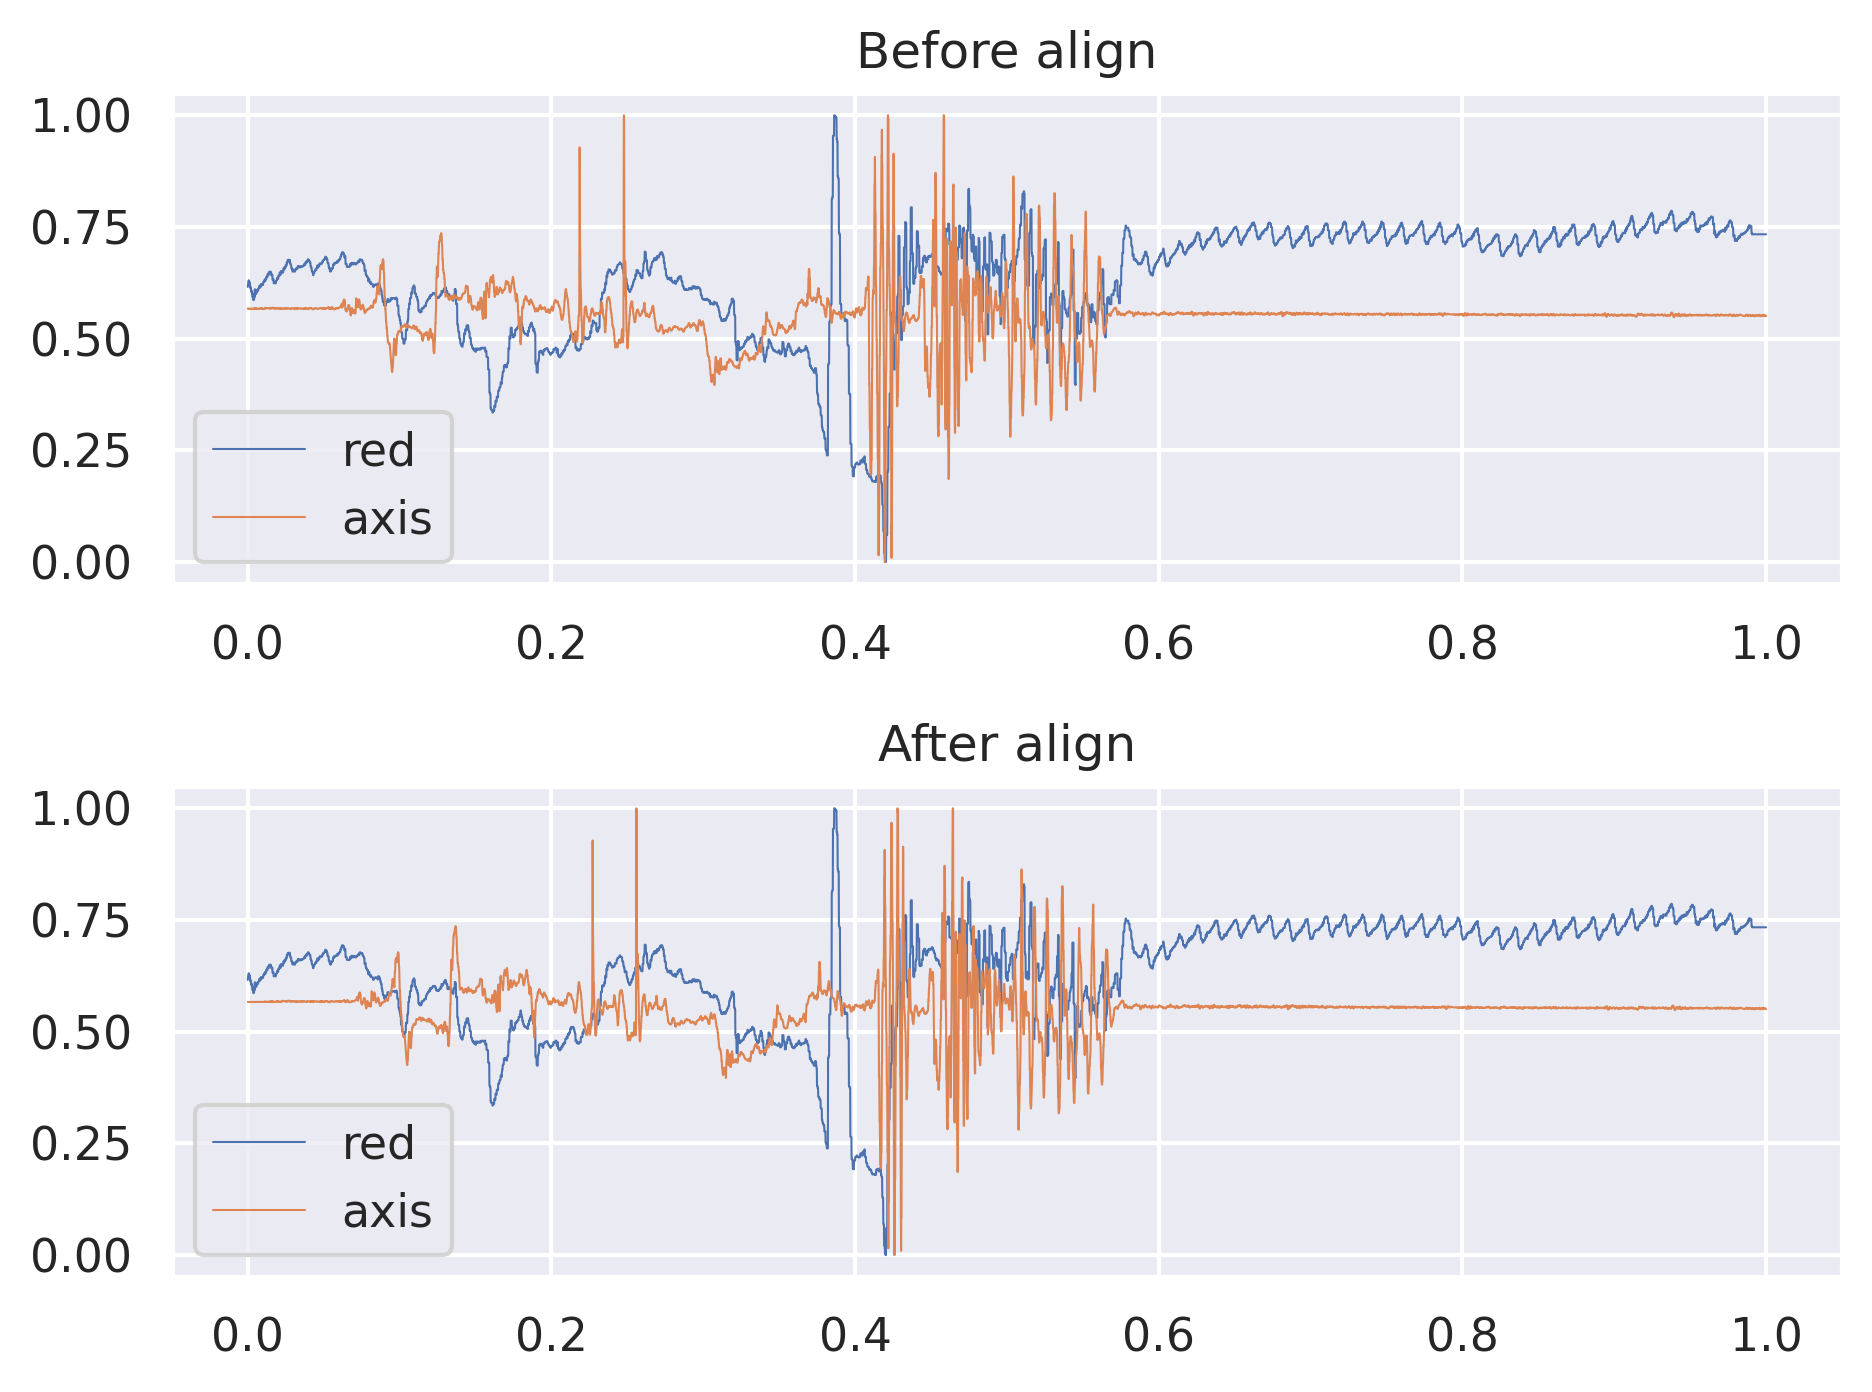

In [203]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(np.linspace(0, 1, len(df['red'])), df['red'], lw=0.5)
ax1.plot(np.linspace(0, 1, len(axis)), axis, lw=0.5)
ax1.legend(['red', 'axis'])
ax1.set_title('Before align')
ax2 = plt.subplot(212)
ax2.set_title('After align')
ax2.plot(np.linspace(0, 1, len(df['red'])), df['red'], lw=0.5)
ax2.plot(np.linspace(0, 1, len(axis) + lag), np.concatenate((np.ones(lag) * axis[0], np.array(axis)), axis=0), lw=0.5)
ax2.legend(['red', 'axis'])
plt.tight_layout()